##Importação das bibliotecas

In [ ]:
pip install pandera

In [ ]:
pip install gcsfs

In [5]:
#Biblioteca para conexão
import requests

# Modelagem de dados
import pandas as pd
import pandera as pa

#Conexão com o GCP
from google.cloud import storage
import os

# Ignorando avisos
import warnings
warnings.filterwarnings('ignore')

##Conector GCP


In [7]:
#CONFIGURAÇÃO DA CHAVE DE SEGURANÇA
serviceAccount = '/content/drive/MyDrive/Key/bc17-349312-c624582f6ec6.json' #Caminho da key para conexão com a GCP

os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = serviceAccount

##Requisição do dataset

In [8]:
# URL da API da Alesp
URL_Despesas = 'http://www.al.sp.gov.br/repositorioDados/deputados/despesas_gabinetes.xml'

# Pegando os dados
conexao_01 = requests.get( URL_Despesas )

# Verificando se a API funcinou
print( conexao_01)

<Response [200]>


##Leitura do dataset

In [9]:
dfDespesasOriginal = pd.read_xml(conexao_01.content)

In [10]:
#Backup do DF original
dfDespesas = dfDespesasOriginal.copy() 

In [11]:
dfDespesas.head(5)

,Ano,Matricula,Mes,Valor,CNPJ,Deputado,Tipo,Fornecedor
0,2015,300257,3,200.00,71806251000106,ABELARDO CAMARINHA,A - COMBUSTÍVEIS E LUBRIFICANTES,AUTO POSTO DE SERVIÇOS MARV LTDA
1,2015,300257,3,295.40,68064740000125,ABELARDO CAMARINHA,E - MATERIAIS DE ESCRITÓRIO E OUTROS MATERIAIS...,PAPER FACE COMERCIAL LTDA
2,2015,300257,3,2850.00,22145388877,ABELARDO CAMARINHA,N - MORADIA,LARA SERVINO VARGAS ABREU
3,2015,300257,4,100.00,10915883000113,ABELARDO CAMARINHA,A - COMBUSTÍVEIS E LUBRIFICANTES,CENTRO AUTOMOTIVO TOP 23 LTDA
4,2015,300257,4,195.01,71806251000106,ABELARDO CAMARINHA,A - COMBUSTÍVEIS E LUBRIFICANTES,AUTO POSTO DE SERVIÇOS MARV LTDA


##Pré-ánalise

In [12]:
dfDespesas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526922 entries, 0 to 526921
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Ano         526922 non-null  int64  
 1   Matricula   526922 non-null  int64  
 2   Mes         526922 non-null  int64  
 3   Valor       526922 non-null  float64
 4   CNPJ        516162 non-null  object 
 5   Deputado    526922 non-null  object 
 6   Tipo        526922 non-null  object 
 7   Fornecedor  526922 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 32.2+ MB


In [13]:
#Verificando inconsistências em cada coluna, realizar coluna por coluna
pd.unique(dfDespesas['Tipo'])

array(['A - COMBUSTÍVEIS E LUBRIFICANTES',
       'E - MATERIAIS DE ESCRITÓRIO E OUTROS MATERIAIS DE CONSUMO',
       'N - MORADIA',
       'H - SERV.UTIL.PÚBLICA (TELEF.MÓVEL/FIXA, ENERGIA, ÁGUA, GÁS ETC)',
       'J - SERVIÇOS DE COMUNICAÇÃO',
       'D - MATERIAIS E SERVIÇOS GRÁFICOS, DE CÓPIAS  E REPRODUÇÃO DE DOCS',
       'G - ASSINATURAS DE PERIÓDICOS, PUBLICAÇÕES, INTERNET E SOFTWARES',
       'C - MATERIAIS E SERVIÇOS DE MANUT E CONSERV DE VEÍCULOS ; PEDÁGIOS',
       'K - LOCAÇÃO DE BENS MÓVEIS',
       'M - MANUTENÇÃO DE BENS MÓVEIS,  IMÓVEIS, CONDOMÍNIOS E OUTROS',
       'F - SERVIÇOS TÉCNICOS PROFISSIONAIS (CONSULTORIA, PESQUISAS ETC)',
       'I - HOSPEDAGEM, ALIMENTAÇÃO E DESPESAS DE LOCOMOÇÃO',
       'O - LOCAÇÃO DE VEÍCULO', 'L - LOCAÇÃO DE BENS IMÓVEIS',
       'B - LOCAÇÃO E MANUT DE BENS MÓVEIS E IMÓVEIS, CONDOMÍNIOS E OUTROS',
       'P - DIVULGAÇÃO DA ATIVIDADE PARLAMENTAR'], dtype=object)

In [ ]:
#Verificando inconsistências em CNPJS válidos
cpfsValidos = dfDespesas.loc[dfDespesas.CNPJ.notnull()]
sorted(cpfsValidos["CNPJ"].unique(),reverse=True)

In [14]:
#Verificando inconsistências na coluna fornecedor onde os CNPJs são inválidos
cnpjInvalidos = dfDespesas.loc[dfDespesas.CNPJ.isnull()]
cnpjInvalidos["Fornecedor"].unique()

array(['PEDÁGIO', 'TAXI', 'PEDAGIO', 'PEDÁGIOS', 'DELTA RADIO TAXI',
       'PEDAGIOS', 'PEGAGIO', 'ELOY DE PAULA JUNIOR',
       'LEANDRO MATOS NICOLELA',
       'CONCESSIONARIA RODOVIA OESTE DE SAO PAULO S.A.',
       'CUPONS DE PEDÁGIO'], dtype=object)

Inconsistências encontradas na coluna Fornecedor onde os CNPJs são nulos:\
PEDAGIO = PEDÁGIO, PEDAGIO, PEDÁGIOS, CUPONS DE PEDÁGIO,PEDAGIOS, PEGAGIO, CONCESSIONARIA RODOVIA OESTE DE SAO PAULO S.A.\
TAXI = TAXI, DELTA RADIO TAXI

Inconsistências na coluna CNPJ onde os CNPJs são válidos\
['O7482309000104',
 'O4689799000126',
 'O4040553000129',
 'O2358317000120',
 'O1520430000105',]


In [15]:
#Contando os valores nulos na coluna CNPJ
dfDespesas.CNPJ.isnull().sum()

10760

Total de valores nulos na coluna CNPJ: 10725

##Tratamento dos dados

In [16]:
#Mudando todos os valores semelhantes a PEDAGIO
dfDespesas["Fornecedor"].replace(["PEDÁGIO","PEDÁGIOS","CUPONS DE PEDÁGIO","PEGAGIO","PEDAGIOS","CONCESSIONARIA RODOVIA OESTE DE SAO PAULO S.A."],"PEDAGIO",inplace=True)

In [17]:
#Mudando todos os valores semelhantes a TAXI
dfDespesas["Fornecedor"].replace("DELTA RADIO TAXI","TAXI", inplace=True)

In [18]:
#Verificando as mudanças
cnpjInvalidos = dfDespesas.loc[dfDespesas.CNPJ.isnull()]
cnpjInvalidos["Fornecedor"].unique()

array(['PEDAGIO', 'TAXI', 'ELOY DE PAULA JUNIOR',
       'LEANDRO MATOS NICOLELA'], dtype=object)

In [19]:
#Retirando letras da coluna CNPJ
dfDespesas["CNPJ"].replace(r"[a-zA-Z]","",regex=True,inplace=True)

##Validação dos dados

In [20]:
#Verificando valores nulos
dfDespesas.isna().sum()

Ano               0
Matricula         0
Mes               0
Valor             0
CNPJ          10760
Deputado          0
Tipo              0
Fornecedor        0
dtype: int64

In [21]:
#Infos geral do DF
dfDespesas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526922 entries, 0 to 526921
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Ano         526922 non-null  int64  
 1   Matricula   526922 non-null  int64  
 2   Mes         526922 non-null  int64  
 3   Valor       526922 non-null  float64
 4   CNPJ        516162 non-null  object 
 5   Deputado    526922 non-null  object 
 6   Tipo        526922 non-null  object 
 7   Fornecedor  526922 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 32.2+ MB


In [22]:
from pandera.engines.numpy_engine import String
from pandera.schema_components import Column

#Construção do Schema para realizar a validação
schema = pa.DataFrameSchema(
    columns = {
        "Ano":pa.Column(pa.Int),
        "Matricula":pa.Column(pa.Int),
        "Mes":pa.Column(pa.Int),
        "Valor":pa.Column(pa.Float),
        "CNPJ":pa.Column(pa.String,nullable=True),
        "Deputado":pa.Column(pa.String),
        "Tipo":pa.Column(pa.String),
        "Fornecedor":pa.Column(pa.String)
    }
)

In [23]:
#Validação
schema.validate(dfDespesas)

,Ano,Matricula,Mes,Valor,CNPJ,Deputado,Tipo,Fornecedor
0,2015,300257,3,200.00,71806251000106,ABELARDO CAMARINHA,A - COMBUSTÍVEIS E LUBRIFICANTES,AUTO POSTO DE SERVIÇOS MARV LTDA
1,2015,300257,3,295.40,68064740000125,ABELARDO CAMARINHA,E - MATERIAIS DE ESCRITÓRIO E OUTROS MATERIAIS...,PAPER FACE COMERCIAL LTDA
2,2015,300257,3,2850.00,22145388877,ABELARDO CAMARINHA,N - MORADIA,LARA SERVINO VARGAS ABREU
3,2015,300257,4,100.00,10915883000113,ABELARDO CAMARINHA,A - COMBUSTÍVEIS E LUBRIFICANTES,CENTRO AUTOMOTIVO TOP 23 LTDA
4,2015,300257,4,195.01,71806251000106,ABELARDO CAMARINHA,A - COMBUSTÍVEIS E LUBRIFICANTES,AUTO POSTO DE SERVIÇOS MARV LTDA
...,...,...,...,...,...,...,...,...
526917,2007,300441,3,120.00,06306675000140,ÍTALO CARDOSO,"I - HOSPEDAGEM, ALIMENTAÇÃO E DESPESAS DE LOCO...",OPTEI EXPRESS LTDA.
526918,2007,300441,3,2096.80,52204617000122,ÍTALO CARDOSO,"I - HOSPEDAGEM, ALIMENTAÇÃO E DESPESAS DE LOCO...",CHURRASCARIA JANDA LTDA.
526919,2007,300441,3,13.48,62925474000282,ÍTALO CARDOSO,"I - HOSPEDAGEM, ALIMENTAÇÃO E DESPESAS DE LOCO...",ASSOCIAÇÃO FUNC.ASSEMB.LEG. EST.SÃO PAULO
526920,2007,300441,3,38.08,66747577000170,ÍTALO CARDOSO,"I - HOSPEDAGEM, ALIMENTAÇÃO E DESPESAS DE LOCO...",IBIZA EUROPEIA ALIMENTOS LTDA


#Insights

##Insight 1
Valores total dos gastos por cada deputado nos ultimos 4 anos




In [24]:
#Filtro dos 4 últimos naos
df4anos = dfDespesas.loc[dfDespesas['Ano']>2018]

In [25]:
insight1 = df4anos.groupby(["Deputado"])["Valor"].sum().sort_values(ascending=False)

In [26]:
insight1

Deputado
ENIO TATTO                           1229299.40
VINÍCIUS CAMARINHA                   1216215.89
TEONILIO BARBA                       1213887.43
MARTA COSTA                          1184537.64
JORGE WILSON XERIFE DO CONSUMIDOR    1174326.22
                                        ...    
ANTONIO SALIM CURIATI                   2418.90
MAJOR MAURO                             2311.53
LUIZ GONZAGA VIEIRA                     2251.96
CARLOS BEZERRA JR.                      1467.37
PEDRO KAKÁ                              1302.67
Name: Valor, Length: 151, dtype: float64

##Insight 2
Mostrar os itens dos ultimos quatro anos onde se mais teve despesa 

In [27]:
insight2 = df4anos.groupby(["Tipo"])["Valor"].sum().sort_values(ascending=False)

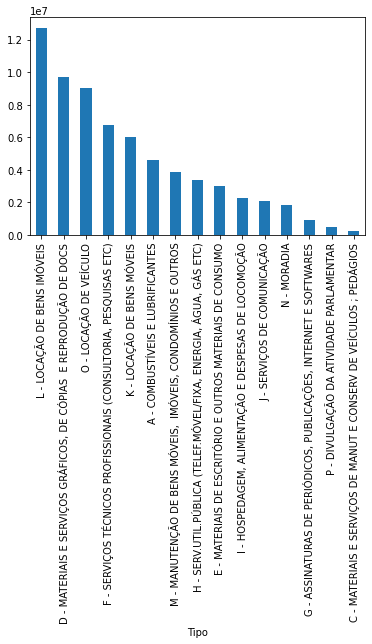

In [28]:
insight2.plot.bar()

##Insight 3
Mostrar os 3 deputados que mais e menos gastam

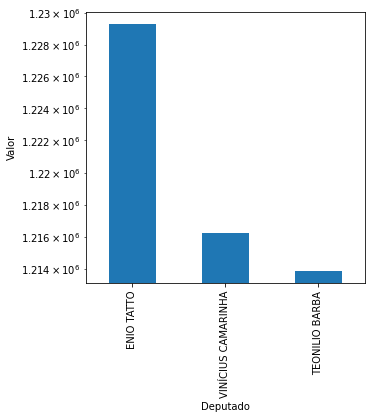

In [29]:
insight1.head(3).plot.bar(figsize=(5,5),ylabel="Valor",logy=True)

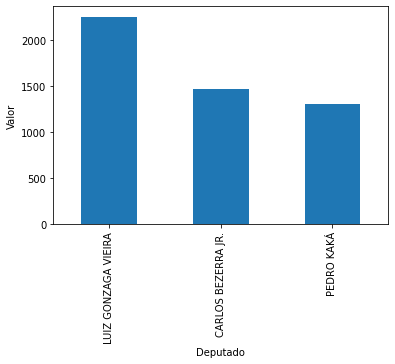

In [30]:
insight1.tail(3).plot.bar(ylabel="Valor")

##Insight 4
5 fornecedores com mais gastos e menos gastos

In [31]:
insight3 = dfDespesas.groupby("Fornecedor")["Valor"].sum().sort_values(ascending=False)
insight3.head(5)

Fornecedor
TELEFONICA                      3187329.01
TELEFONICA BRASIL S.A.          2966690.70
TELEFÔNICA BRASIL S.A.          2308472.82
TELEFONICA BRASIL S.A           2235050.65
NEXTEL TELECOMUNICAÇÕES LTDA    2159869.40
Name: Valor, dtype: float64

In [32]:
insight3.tail(5)

Fornecedor
CLUBE PAINEIRAS DO MORUMBY                       0.01
LA BRETAGNE                                      0.00
PIZZARIA E RESTAURANTE CERRO CORA LTDA. - EPP    0.00
DPT NOTÍCIAS E PUBLICIDADE S/C LTDA.             0.00
AUTO POSTO TRES ALIANCAS LTDA                    0.00
Name: Valor, dtype: float64

##Insight 5
Total de gastos em cada ano

In [33]:
insight4 = dfDespesas.groupby("Ano")["Valor"].sum().sort_values(ascending=False)
insight4

Ano
2017    23408256.71
2016    22844787.47
2013    21996182.92
2018    21805727.79
2021    21726688.72
2015    20847302.59
2014    19793197.11
2009    19692011.71
2019    19437855.90
2012    19250086.55
2011    18666881.69
2006    18397375.96
2007    18390011.24
2010    18361598.00
2005    18151570.81
2008    17808751.18
2004    17248832.18
2020    16949849.75
2003    15834964.24
2002    11122821.42
2022     8810100.49
Name: Valor, dtype: float64

#Load

In [ ]:
schema.validate(dfDespesas)

In [ ]:
#Carregamento do arquvio no formato CSV para a GCP 
dfDespesas.to_csv("gs://nome_bucket/Tratados/despesas_gabinetes.csv",index=False)